In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Voting History Table

In [63]:
vdf = pd.read_csv('/Users/willmayer/Desktop/DS3001/project/DS3001-Final-Project/data/voting_VA.csv', low_memory=False) # Voting history by county
vdf = vdf[vdf['year'] != 2000]
vdf = vdf[vdf['year'] != 2004]

path = '/Users/willmayer/Desktop/DS3001/DS3001-Final-Project/data/county_data/utf8_justVA' # County demographics
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
dfs = {}
for file in csv_files:
    file_path = os.path.join(path, file)
    dfs[file] = pd.read_csv(file_path) # Dictionary of demographic tables

2020 was split into three observations/candidate b/c of alternative voting methods--this block cleans every 3 rows to a 'total' column

In [64]:
df2020 = vdf.loc[vdf['year']==2020,:] 
df2020 = df2020.reset_index(drop=True) 
df2020['group'] = df2020.index // 3     # Create a group identifier every 3 rows

# Dynamically create an aggregation dictionary
# Use 'first' for all columns except 'candidatevotes', which should be summed
agg_dict = {col: 'first' for col in df2020.columns if col != 'candidatevotes'}
agg_dict['candidatevotes'] = 'sum'  # Summing only the 'candidatevotes' column

df_collapsed = df2020.groupby('group').agg(agg_dict).reset_index(drop=True)

df_collapsed = df_collapsed.drop(columns=['group'], errors='ignore')

In [65]:
vdf_filtered = vdf[vdf['year'] != 2020] # Put fixed 2020 back together
vdf = pd.concat([vdf_filtered, df_collapsed], ignore_index=True)
vdf['mode'] = 'TOTAL' # All the counts are totals now

From the voting dataframe, make a tidy dataset where each observation is a (year, county) pair. We can eventually add demographic information.

In [66]:
df_dem = vdf[vdf['party']=='DEMOCRAT'] # Make 'dvotes' 'rvotes' and 'ivotes' columns
df_rep = vdf[vdf['party']=='REPUBLICAN']
df_other = vdf[vdf['party']=='OTHER']
df_dem_sum = df_dem.groupby(['county_fips', 'year'])['candidatevotes'].sum().reset_index(name='dvotes')
df_rep_sum = df_rep.groupby(['county_fips', 'year'])['candidatevotes'].sum().reset_index(name='rvotes')
df_other_sum = df_other.groupby(['county_fips', 'year'])['candidatevotes'].sum().reset_index(name='ivotes')
df_votes = pd.merge(df_dem_sum, df_rep_sum, on=['county_fips', 'year'], how='outer')
df_votes = pd.merge(df_votes, df_other_sum, on=['county_fips','year'],how='outer')

Calculate the winner and margin for each year-county pair

In [67]:
def winner(row):
    votes = {0: row['dvotes'], 1: row['rvotes'], 2: row['ivotes']}
    return max(votes, key=votes.get)
def margin(row):
    return row['dvotes'] - row['rvotes']
def sumvotes(row):
    return row['rvotes'] + row['dvotes'] + row['ivotes'] 

To have a meaningful margin variable, we have to drop the one row where an independent won

In [68]:
df_votes['winner'] = df_votes.apply(winner, axis=1) # Make 'winner,' 'margin,' and 'total_votes' columns
df_votes['margin'] = df_votes.apply(margin, axis=1)
df_votes['total_votes'] = df_votes.apply(sumvotes, axis=1)

In [69]:
df_votes[df_votes['winner'] == 2]

,county_fips,year,dvotes,rvotes,ivotes,winner,margin,total_votes
534,51840,2020,1624,2396,2849.0,2,-772.0,6869.0


In [70]:
df_votes.loc[df_votes['winner']==2] = np.nan

Create an index to make matching easy

In [71]:
df_votes = df_votes.reset_index(drop=False)

## Merge demographic information with vote information

Each observation is a year-county pair with a bunch of demographic columns

The demographic years are in intervals so we have to match them to election years

In [72]:
dfs['0002_ds206_20145_county_E.csv']['YEAR'] = 2012
dfs['0002_ds239_20185_county_E.csv']['YEAR'] = 2016
dfs['0002_ds249_20205_county_E.csv']['YEAR'] = 2020
dfs['0002_ds176_20105_county_E.csv']['YEAR'] = 2008

Put the 5 demographic tables together (stacked)

In [73]:
stacked_r = pd.concat(dfs.values(),ignore_index=True) 
stacked_r.rename(columns={'YEAR':'year','COUNTYA':'county_fips'}, inplace=True)
df_votes['county_fips'] = df_votes['county_fips'] - 51000

Match voting history with demographics

In [74]:
df_votes = pd.merge(df_votes, stacked_r, on=['county_fips', 'year'], how='left')

### Melt Demographics Variables

Each demographic table (year) has a different column name for a given variable, so we'll have to identify each variable we want to use and put it in the melter. For now, we'll start with median household income, total population, and % white population in each county.

In [75]:
def melter(df, map, index, name):
    x = df.rename(columns=map).melt(id_vars=[index], value_vars=map.values(), value_name=name)
    x = x.drop(columns=['variable']).dropna()
    return pd.merge(df, x[[index, name]], on=index, how='left')

In [76]:
df = df_votes
income_map = {
    'JOHE001':'Income1',
    'QU0E001':'Income2',
    'ABDOE001':'Income3',
    'AJY9E001':'Income4',
    'AMR7E001':'Income5',
}

white_map = {
    'JMBE002':'White1',
    'QSQE002':'White2',
    'ABA2E002':'White3',
    'AJWNE002':'White4',
    'AMPWE002':'White5'
}

pop_map = {
    'JMAE001':'pop1',
    'QSPE001':'pop2',
    'ABA1E001':'pop3',
    'AJWME001':'pop4',
    'AMPVE001':'pop5'
}

rent_map = {
    'JS5E001':'rent1',
    'ABIHE001':'rent2',
    'AJ3EE001':'rent3',
    'QZTE001':'rent4',
    'AMVZE001':'rent5'
}

poverty_map = {
    'JOCE001' : 'p1',
    'ABDJE001': 'p2',
    'AJY4E001': 'p3',
    'AMZME001': 'p4',
    # 'AMZMM001': 'p5'
}

maps = {
    'income': income_map,
    'totpop': pop_map,
    'whitepop': white_map,
    'median_rent': rent_map,
    'poverty_ratio': poverty_map
}

index = 'index'

for name, map in maps.items():
    df = melter(df, map, index, name)

Calculate percent white for graphing purposes

In [77]:
df['pctwhite'] = (df['whitepop'] / df['totpop']) * 100

Reorder columns--clean dataseet! We can update this to include more variables as we find them in the codebook.

In [78]:
df = df.loc[:, ~df.columns.duplicated()]

## Plots

Text(0.5, 1.0, 'Democrats win counties by larger margins')

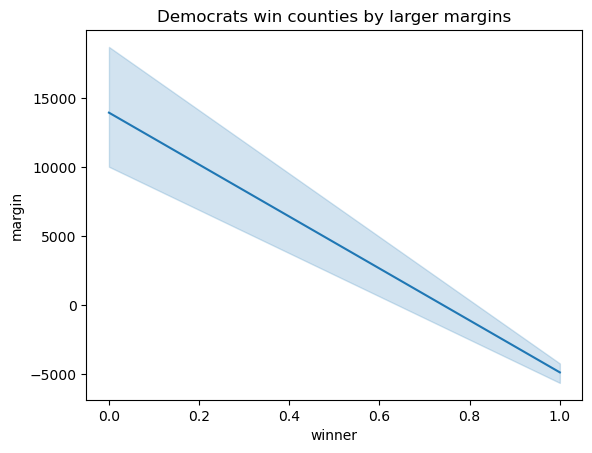

In [79]:
sns.lineplot(df, x='winner', y='margin')
plt.title('Democrats win counties by larger margins')

Text(0.5, 1.0, 'Median annual household income by county. X=1 means county voted Republican')

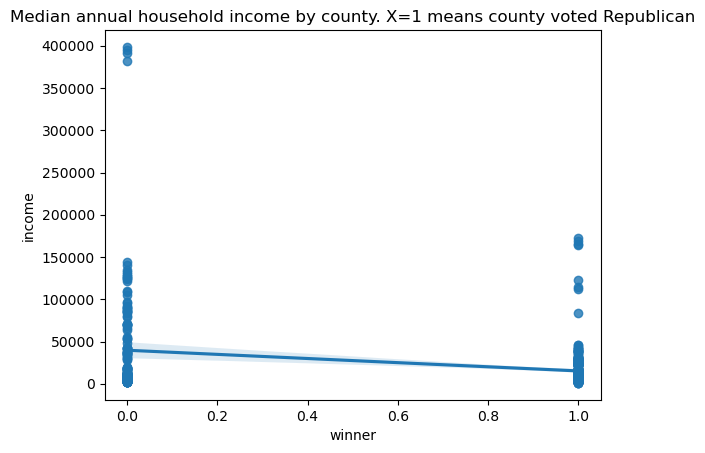

In [80]:
sns.regplot(data=df, x='winner', y='income')
plt.title('Median annual household income by county. X=1 means county voted Republican')

Text(0.5, 1.0, '% White Population in County. X=1 means county voted Republican.')

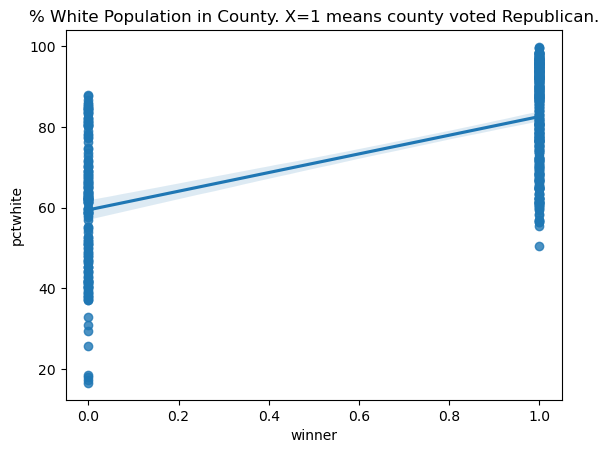

In [81]:
sns.regplot(df, x='winner', y='pctwhite')
plt.title("% White Population in County. X=1 means county voted Republican.")

Text(0.5, 1.0, 'Margin of Victory Over Time')

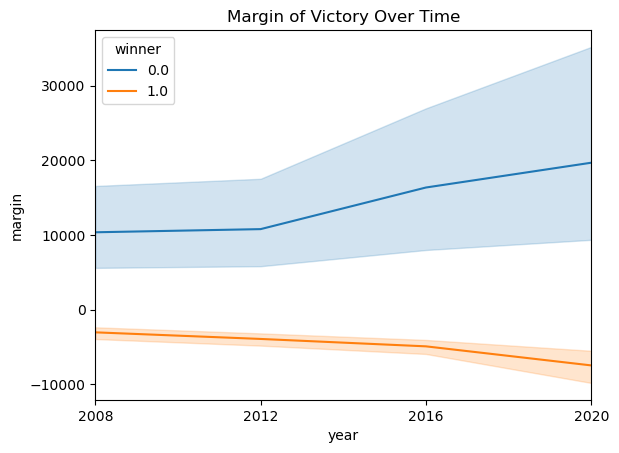

In [82]:
sns.lineplot(df, x='year', y='margin', hue='winner') # Interesting choice of hues
xticks = [2008, 2012, 2016, 2020]
plt.xticks(xticks)
plt.xlim(2008, 2020)
plt.title('Margin of Victory Over Time')

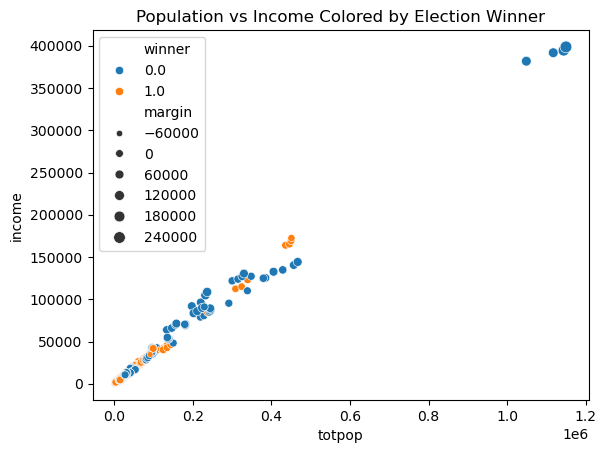

In [83]:
sns.scatterplot(df, x='totpop', y='income', hue='winner', size='margin') # See fairfax VA in the top right
plt.title('Population vs Income Colored by Election Winner')
plt.show()

Text(0.5, 1.0, 'Voter turnout increases over year')

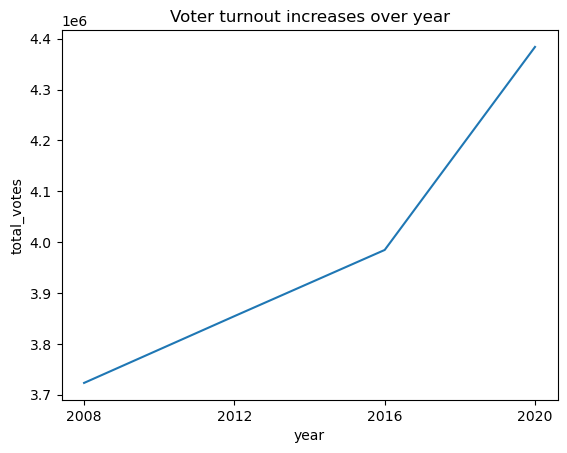

In [84]:
yearly = df.groupby('year')['total_votes'].sum()
yearly = df.groupby('year', as_index=False)['total_votes'].sum()

sns.lineplot(data=yearly, x='year', y='total_votes')
plt.xticks(xticks)
plt.title('Voter turnout increases over year')

*Testing if we should reduce to principal components*

In [85]:
variables = ['total_votes', 'income', 'poverty_ratio', 'median_rent', 'totpop', 'whitepop']
X = df.loc[:, variables]

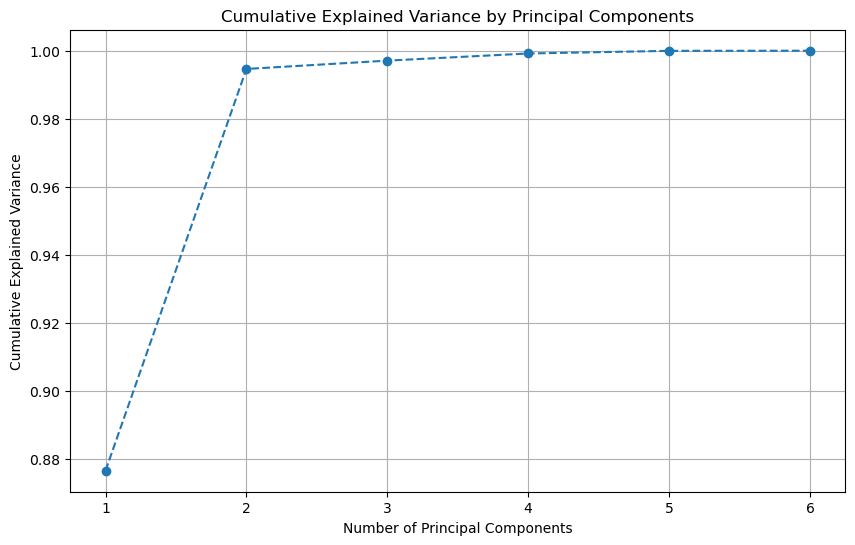

In [86]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X = X.dropna()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

pca = PCA()
pca_result = pca.fit_transform(scaled_data)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance = explained_variance_ratio.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [87]:
pca = PCA(n_components = 2)
pca = pca.fit(X)
Z = pca.transform(X)

In [88]:
loadings = pd.DataFrame(
    pca.components_,
    columns=X.columns,
)
loadings

,total_votes,income,poverty_ratio,median_rent,totpop,whitepop
0,0.292520,0.215223,0.599103,0.000762,0.606999,0.375150
1,0.017088,-0.097062,-0.235908,0.000175,-0.307459,0.916572


Principal components not needed

*Final Preprocessing*

Because we have major outliers (Fairfax County), we'll log-scale values for income and median rent. This will attempt to reduce the bias of counties with large populations.

In [89]:
p = df['totpop']
p = p.sort_values()
p.tail()

114    1143529.0
115    1149439.0
385          NaN
386          NaN
534          NaN
Name: totpop, dtype: float64

In [90]:
df[df['totpop'] > 1_000_000]

,index,county_fips,year,dvotes,rvotes,ivotes,winner,margin,total_votes,GISJOIN,...,QX8E002,QX8E003,QZTE001,QZ6E001,income,totpop,whitepop,median_rent,poverty_ratio,pctwhite
112,112,59.0,2008.0,310359.0,200994.0,4901.0,0.0,109365.0,516254.0,G5100590,...,NaN,NaN,NaN,NaN,381768.0,1048554.0,680404.0,1492.0,1039870.0,64.889743
113,113,59.0,2012.0,315273.0,206773.0,7241.0,0.0,108500.0,529287.0,G5100590,...,NaN,NaN,NaN,NaN,391794.0,1117072.0,705991.0,1724.0,1107694.0,63.200134
114,114,59.0,2016.0,355133.0,157710.0,38340.0,0.0,197423.0,551183.0,G5100590,...,NaN,NaN,NaN,NaN,394447.0,1143529.0,708761.0,1851.0,1133591.0,61.980151
115,115,59.0,2020.0,419943.0,168401.0,4885.0,0.0,251542.0,593229.0,G5100590,...,NaN,NaN,NaN,NaN,398653.0,1149439.0,678162.0,1898.0,1138999.0,58.999390


In [91]:
df['income_log'] = np.log(df['income'])
df['median_rent_log'] = np.log(df['median_rent'])

The features of our final model include:
- Income (log-scale)
- Median rent (log-scale)
- Poverty-ratio
- % of population identifying as white

One observation of our model is a given county in Virginia in a given year (2008, 2012, 2016, 2020)

The target variable of our model is the margin of victory, coded as

$Margin = Democrat Votes - Republican Votes$

At the state level, because the relevant number to predict is the total number of votes a candidate won, the variable of interest for our model is the margin of victory for that year.

In [92]:
vars = ['income_log', 'poverty_ratio', 'median_rent_log', 'whitepop']
df = df.dropna(subset=vars)
X = df.loc[:, vars]
y = df.loc[:, ['margin']]

In [93]:
y = y['margin']

Finally, before fitting the model, we'll standard scale our feature variables. The standard scaler ensures that all features have similar scales by centering each column to a mean of 0 with a standard deviation of 1. This way, the coefficients to our variabels will be more easily interpretable as "a one-standard deviation increase in x is associated with a y increase in margin." This also ensures that our features with larger ranges do not dominate the model's variance.

In [94]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model


scaler = StandardScaler()
scaler.fit(X)
X_sc = scaler.transform(X)

**Linear model**

First, we will split the data into an 80 / 20 train/test split to ensure our model does not overfit to the data.

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_sc,y, test_size=.2, random_state=100)

For this project, we'll use a linear regression model. We'll use regression because we want to predict a continuous variable (the margin of victory in a county in a given year). We'll use a linear model because the coefficients provide the best explainability to understand how changes in each feature, all else held constant, are associated with changes in voting behavior.

In [96]:
reg = linear_model.LinearRegression(fit_intercept=False).fit(X_train,y_train) 
y_hat = reg.predict(X_test)
print('Rsq: ', reg.score(X_test,y_test)) # R2
rmse = np.sqrt( np.mean( (y_test - y_hat)**2 ))
print('RMSE: ', rmse) # R2

Rsq:  0.5769743848947966
RMSE:  7918.869726832508


Here are the feature variables and their coefficients for the linear model

In [99]:
results = pd.DataFrame({'variable':X.columns, 'coefficient': reg.coef_})
results

,variable,coefficient
0,income_log,-4207.879026
1,poverty_ratio,68102.556893
2,median_rent_log,1000.101259
3,whitepop,-50501.407458


Finally, we'll use a LASSO model to ensure that our model is not overfitting to the data. If the model's performance does not improve significantly, we'll know the linear model is the best bet with our current tools.

*LASSO*

In [100]:
reg = linear_model.Lasso(alpha=1.0,
                         warm_start=True,
                         max_iter=2000,
                         fit_intercept=True)
reg.fit(X_train,y_train)
y_hat = reg.predict(X_test)
print('Rsq: ', reg.score(X_test,y_test)) # R2
rmse = np.sqrt( np.mean( (y_test - y_hat)**2 ))
print('RMSE: ', rmse) # R2

Rsq:  0.5821427891670229
RMSE:  7870.345831843732


Here are the feature variables and their coefficients for the LASSO

In [101]:
results = pd.DataFrame({'variable':X.columns, 'coefficient': reg.coef_})
results

,variable,coefficient
0,income_log,-4241.614570
1,poverty_ratio,68380.829142
2,median_rent_log,986.398279
3,whitepop,-50776.745230
